In [1]:
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import keras
keras.__version__

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'dispatch'

In [2]:
tf.__version__

'2.4.1'

In [8]:
mnist = tf.keras.datasets.mnist

In [9]:
from keras import backend as K
K.clear_session()

# 生成图像

## 变分自编码器

自编码器由 Kingma 和 Welling 于 2013 年 12 月 a 与 Rezende、Mohamed 和 Wierstra 于 2014 年 1 月 同时发现，它是一种生成式模型，特别适用于利用概念向量进行图像编辑的任务。它是 一种现代化的自编码器，将深度学习的想法与贝叶斯推断结合在一起。自编码器是一种网络类型， 其目的是将输入编码到低维潜在空间，然后再解码回来。

经典的图像自编码器接收一张图像，通过一个编码器模块将其映射到潜在向量空间，然后再通过一个解码器模块将其解码为与原始图像具有相同尺寸的输出（见图）。然后，使用与输入图像相同的图像作为目标数据来训练这个自编码器，也就是说，自编码器学习对原始输入进行重新构建。通过对代码（编码器的输出）施加各种限制，我们可以让自编码器学到比较有 趣的数据潜在表示。最常见的情况是将代码限制为低维的并且是稀疏的（即大部分元素为 0），在这种情况下，编码器的作用是将输入数据压缩为更少二进制位的信息。


![Autoencoder](autoencoder.jpg)

在实践中，这种经典的自编码器不会得到特别有用或具有良好结构的潜在空间。它们也没有对数据做多少压缩。因此，它们已经基本上过时了。但是，VAE 向自编码器添加了一点统计魔法，迫使其学习连续的、高度结构化的潜在空间。这使得 VAE 已成为图像生成的强大工具。

VAE 不是将输入图像压缩成潜在空间中的固定编码，而是将图像转换为统计分布的参数，即平均值和方差。本质上来说，这意味着我们假设输入图像是由统计过程生成的，在编码和解码过程中应该考虑这一过程的随机性。然后，VAE 使用平均值和方差这两个参数来从分布中随机采样一个元素，并将这个元素解码到原始输入（见下图）。这个过程的随机性提高了其稳健性，并迫使潜在空间的任何位置都对应有意义的表示，即潜在空间采样的每个点都能解码为有效的输出。


![VAE](vae.png)

从技术角度来说，VAE 的工作原理如下。
* (1) 一个编码器模块将输入样本 input_img 转换为表示潜在空间中的两个参数 z_mean 和z_log_variance。
* (2) 我们假定潜在正态分布能够生成输入图像，并从这个分布中随机采样一个点 z：z = z_mean + exp(z_log_variance) * epsilon，其中 epsilon 是取值很小的随机 张量。
* (3) 一个解码器模块将潜在空间的这个点映射回原始输入图像。

因为 epsilon 是随机的，所以这个过程可以确保，与 input_img 编码的潜在位 置（即 z-mean）靠近的每个点都能被解码为与 input_img 类似的图像，从而迫使潜在空间能够连续地有意义。潜在空间中任意两个相邻的点都会被解码为高度相似的图像。连续性以及潜在空间的低维度，将迫使潜在空间中的每个方向都表示数据中一个有意义的变化轴，这使得潜在空间具有非常良好的结构，因此非常适合通过概念向量来进行操作。

VAE 的参数通过两个损失函数来进行训练：一个是重构损失（reconstruction loss），它迫使解码后的样本匹配初始输入；另一个是正则化损失（regularization loss），它有助于学习具有良好结构的潜在空间，并可以降低在训练数据上的过拟合。我们来快速浏览一下 Keras 实现的 VAE。其大致代码如下所示。


它是一个简单的卷积神经网络，将输入图像 x 映射为两个向量 z_mean 和 z_log_var。

In [10]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane（潜在空间的维度：一个二维平面）

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

接下来的代码将使用 z_mean 和 z_log_var 来生成一个潜在空间点 z，z_mean 和 z_log_var 是统计分布的参数，我们假设这个分布能够生成 input_img。这里，我们将一些随意的代码（这些代码构建于 Keras 后端之上）包装到 Lambda 层中。在 Keras 中，任何对象都应该是一个层，所以如果代码不是内置层的一部分，我们应该将其包装到一个Lambda 层（或自定义层）中。


In [11]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

下列代码给出了解码器的实现。我们将向量 z 的尺寸调整为图像大小，然后使用几个卷积层来得到最终的图像输出，它和原始图像 input_img 具有相同的大小。

In [12]:
# This is the input where we will feed `z`.（需要将 z 输入到这里）
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units（对输入进行上采样）
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
# 将 z 转换为特征图，使其形状与编码 器模型最后一个 Flatten 层之前的特征图的形状相同
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
# 使用一个 Conv2DTranspose 层和一个Conv2D 层，将 z 解码为与原始输入图像具有相同尺寸的特征图

x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.
# 我们最终获得了与原始输入相同大小的特征映射。

# This is our decoder model.将解码器模型实例化，它将 decoder_input转换为解码后的图像
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
# 将这个实例应用于 z，以得到解码后的 z
z_decoded = decoder(z)

我们一般认为采样函数的形式为 loss(input, target)，VAE 的双重损失不符合这种形式。因此，损失的设置方法为：编写一个自定义层，并在其内部使用内置的 add_loss 层方法来创建一个你想要的损失。


In [13]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.（我们不使用这个输出， 但层必须要有返回值）
        return x

# to obtain the final model output.（对输入和解码后的输出调用自定义层，以得到最终的模型输出）
y = CustomVariationalLayer()([input_img, z_decoded])

最后，将模型实例化并开始训练。因为损失包含在自定义层中，所以在编译时无须指定外部损失（即 loss=None），这意味着在训练过程中不需要传入目标数据。（如你所见，我们在调用 fit 时只向模型传入了 x_train。）


In [14]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                            

Epoch 1/10


TypeError: in user code:

    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\engine\compile_utils.py", line 317, in __call__
        self._total_loss_mean.update_state(
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\metrics\base_metric.py", line 528, in update_state  **
        update_total_op = self.total.assign_add(value_sum)
    File "c:\Users\lenovo\.conda\envs\pytroch\lib\site-packages\keras\src\engine\keras_tensor.py", line 285, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_sum/Sum:0', description="created by layer 'tf.math.reduce_sum'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


一旦训练好了这样的模型（本例中是在 MNIST 上训练），我们就可以使用 decoder 网络将任意潜在空间向量转换为图像。


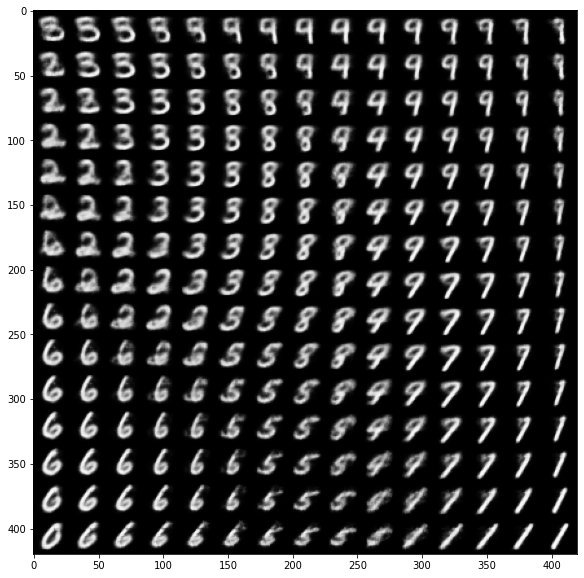

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits（我们将显示 15×15 的数字网格（共 255 个数字））
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 使用 SciPy 的 ppf 函数对线性分隔的坐标进行变换，
# 以生成潜在变量 z 的值（因 为潜在空间的先验分布是高斯分布）

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        #将 z 多次重复，以构建一个完整的批量
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
#         将批量解码为数字图像
        digit = x_decoded[0].reshape(digit_size, digit_size)
    #将批量第一个数字的 形状从 28×28×1 转 变为 28×28
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

采样数字的网格（见上图）展示了不同数字类别的完全连续分布：当你沿着潜在空间的一条路径观察时，你会观察到一个数字逐渐变形为另一个数字。这个空间的特定方向具有一定的意义，比如，有一个方向表示“逐渐变为 4”、有一个方向表示“逐渐变为 1”等。